In [16]:
#!pip install scikit-learn


In [30]:
# import  libraries
from openai import OpenAI
import pandas as pd
from pprint import pprint

In [31]:
import json


client = OpenAI()

def get_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data[0].embedding

In [29]:
# test the function, and print embedding shape for sample text
#text = "We are at Fort Lewis in Durango, Colorado in a session about embeddings."
text = ""

embedding = get_embedding(text)
print(f"Embedding shape: {len(embedding)}")
# pretty print the embedding with line breaks, etc
pprint(embedding, indent=2, width=80)


Embedding shape: 1536
[ -0.013217284344136715,
  0.012738044373691082,
  0.0509243980050087,
  0.006803115829825401,
  -0.002278123516589403,
  0.043423257768154144,
  0.011251707561314106,
  0.032616063952445984,
  -0.004719466436654329,
  -0.029921209439635277,
  0.017030363902449608,
  -0.04053393006324768,
  0.0037575147580355406,
  -0.057175345718860626,
  -0.005730036646127701,
  0.007716448977589607,
  0.03856140747666359,
  0.04625702276825905,
  0.0040110256522893906,
  0.07778958976268768,
  -0.008904129266738892,
  -0.04989646375179291,
  -0.01903066597878933,
  0.04011720046401024,
  -0.0033477304968982935,
  -0.004160353913903236,
  -0.00831376202404499,
  0.04717382788658142,
  0.015807954594492912,
  0.007869250141084194,
  0.020669804885983467,
  -0.04214528575539589,
  -0.037811294198036194,
  -0.020044708624482155,
  -0.02446204610168934,
  -0.00897358451038599,
  -0.0014151453506201506,
  0.040367238223552704,
  -0.0430065281689167,
  0.011411454528570175,
  0.012717

In [19]:
# read json objects, line by line, in json/data-barn-delights.jsonl into a dataframe
df = pd.read_json('json/data-barn-delights.jsonl', lines=True)

In [20]:
# create a new column, named embedding in the dataframe calling get_embedding for text column
df['embedding'] = df['text'].apply(get_embedding)


,id,meta_color,meta_department,text,embedding
0,apple,red,grocery,This fresh red apple is perfect for snacking o...,"[0.004357376601547003, -0.015314856544137001, ..."
1,asparagus,green,grocery,This fresh green asparagus is ideal for health...,"[0.0060213059186935425, -0.024946179240942, 0...."
2,blueberries,blue,grocery,These fresh blue blueberries are perfect for s...,"[0.00741775194182992, -0.026721514761447906, -..."
3,fertilizer,green,garden,This green fertilizer boosts plant growth and ...,"[0.013769866898655891, 0.032659731805324554, 0..."
4,frozen-peas,green,grocery,These green frozen peas are a versatile and he...,"[-0.015473926439881325, -0.03986012190580368, ..."
5,mop,red,cleaning,This red mop is designed for efficient floor c...,"[0.05619010701775551, 0.03280946984887123, -0...."
6,pasta-sauce,red,grocery,This red pasta sauce is perfect for adding fla...,"[-0.05282636731863022, -0.037101104855537415, ..."
7,planting-bed,red,garden,This red planting bed is ideal for creating or...,"[0.0010808962397277355, -0.021274976432323456,..."
8,sponge,green,cleaning,This green sponge is perfect for all your clea...,"[0.028249232098460197, 0.011501634493470192, 0..."
9,sports-drink,blue,grocery,This blue sports drink is designed to keep you...,"[0.03546168655157089, 0.03785005956888199, -0...."


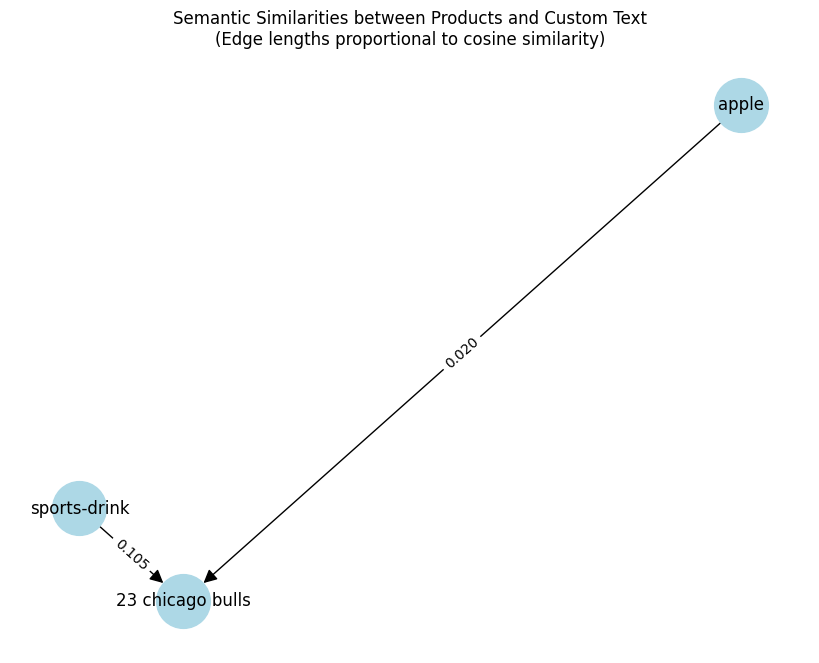

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Define two product IDs and custom text
product1_id = 'apple'
product2_id = 'sports-drink' 
custom_text = "23 chicago bulls"

# Get embeddings for the two products from dataframe
product1_data = df[df['id'] == product1_id]
product2_data = df[df['id'] == product2_id]

# Get embedding for custom text
custom_embedding = get_embedding(custom_text)

if len(product1_data) == 0 or len(product2_data) == 0:
    print(f"Error: Could not find {product1_id} or {product2_id} in the dataset")
else:
    product1_embedding = product1_data['embedding'].values[0]
    product2_embedding = product2_data['embedding'].values[0]

    # Calculate cosine similarities
    p1_custom_sim = cosine_similarity([product1_embedding], [custom_embedding])[0][0]
    p2_custom_sim = cosine_similarity([product2_embedding], [custom_embedding])[0][0]

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges with distances
    G.add_edge(product1_id, custom_text[:20], weight=p1_custom_sim)
    G.add_edge(product2_id, custom_text[:20], weight=p2_custom_sim)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    
    # Create a layout where edge lengths are directly proportional to similarities
    pos = {}
    pos[custom_text[:20]] = np.array([0, 0])  # Place custom text at origin
    
    # Calculate positions based on similarities
    # Higher similarity = shorter distance
    angle_p1 = np.pi/3  # 60 degrees
    angle_p2 = 2*np.pi/3  # 120 degrees
    
    # Scale factor for visualization (inverse of similarity for distance)
    scale = 3.0
    
    pos[product1_id] = np.array([
        scale * (1/p1_custom_sim) * np.cos(angle_p1),
        scale * (1/p1_custom_sim) * np.sin(angle_p1)
    ])
    pos[product2_id] = np.array([
        scale * (1/p2_custom_sim) * np.cos(angle_p2),
        scale * (1/p2_custom_sim) * np.sin(angle_p2)
    ])

    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=1500, arrowsize=20, font_size=12)

    # Add edge labels (similarities)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    edge_labels = {k: f'{v:.3f}' for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title('Semantic Similarities between Products and Custom Text\n(Edge lengths proportional to cosine similarity)')
    plt.show()

/Users/ngoodman/.pyenv/versions/notebooks/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


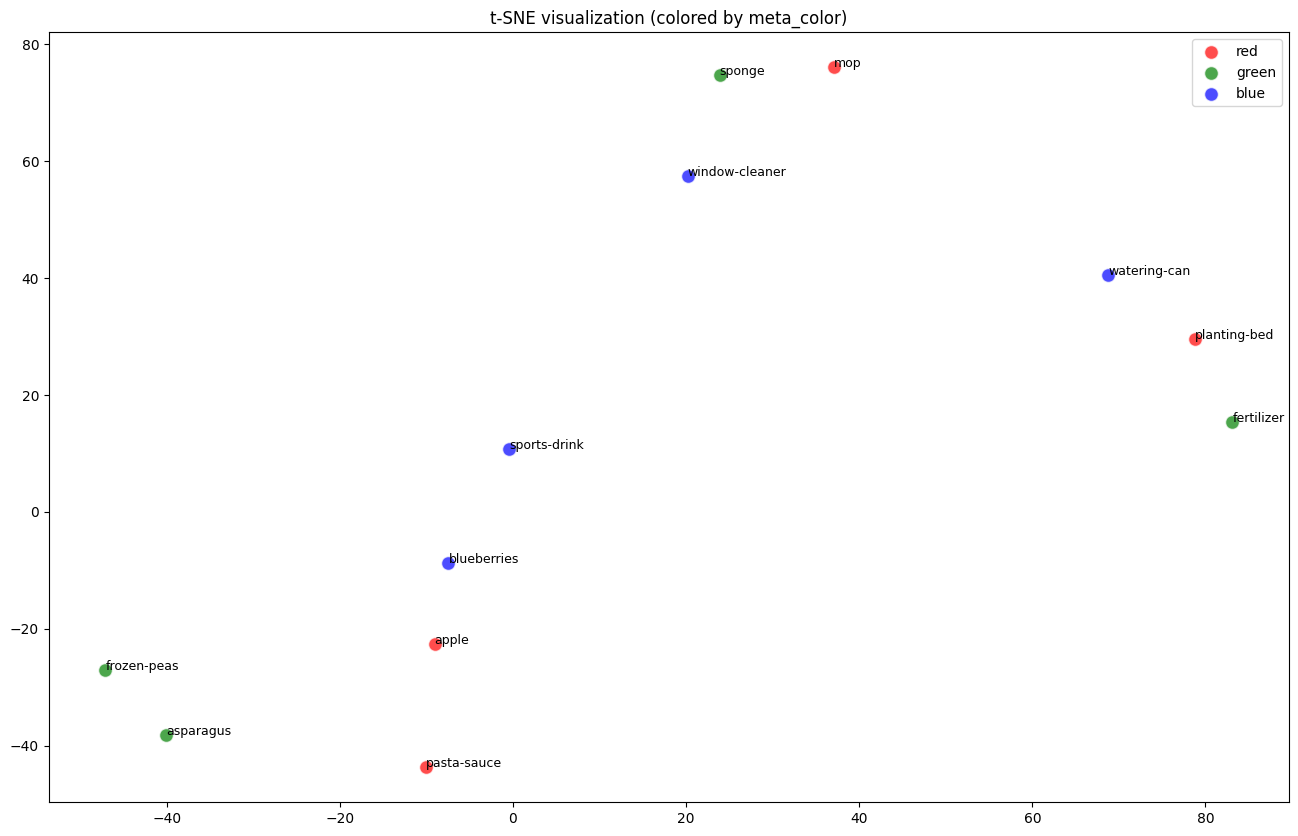

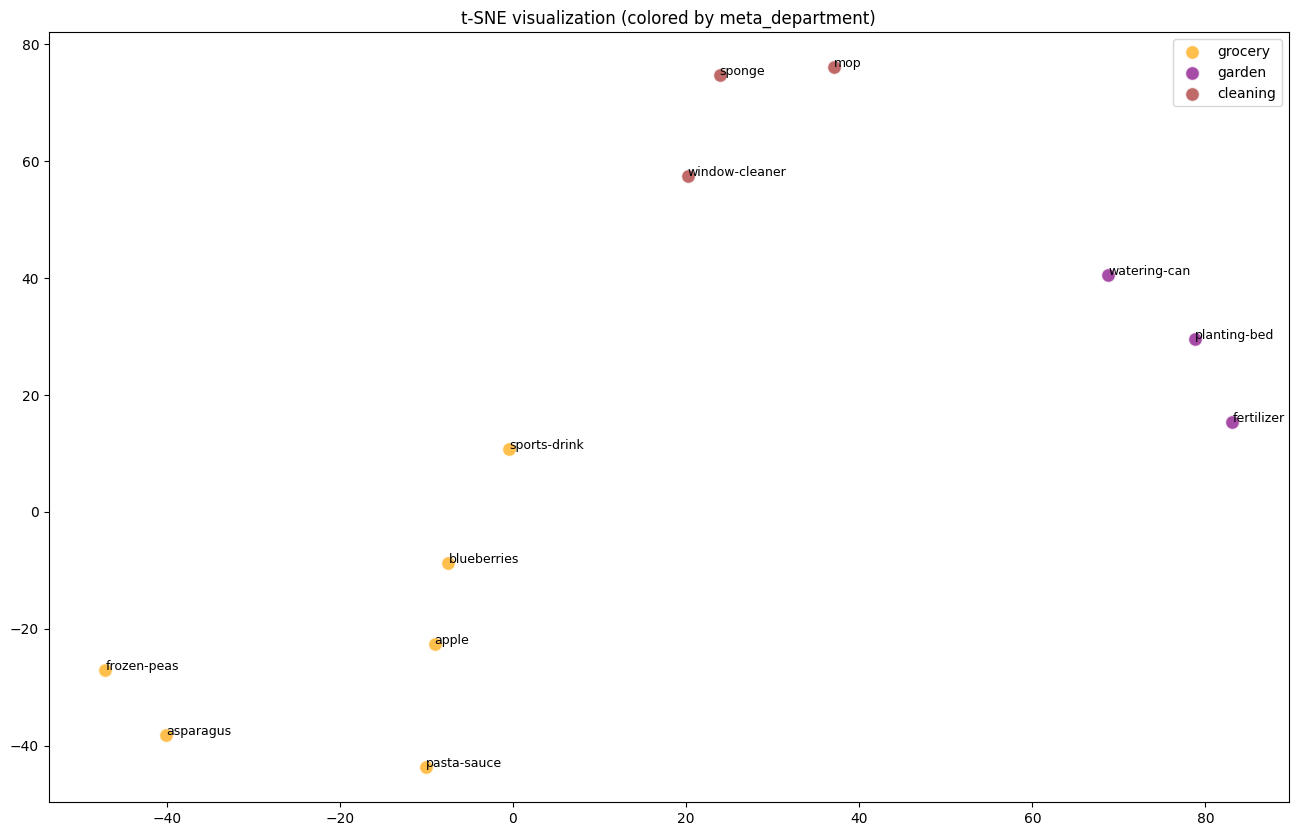

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Sample dataframe based on the provided data

# Convert embeddings to numpy array
embeddings = np.array(df['embedding'].tolist())

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=3, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Add t-SNE results to dataframe
df['tsne-2d-one'] = embeddings_2d[:,0]
df['tsne-2d-two'] = embeddings_2d[:,1]

# Function to plot t-SNE with labels
def plot_tsne(df, label_col, title):
    plt.figure(figsize=(16, 10))
    colors = {'red': 'red', 'green': 'green', 'blue': 'blue'}
    departments = {'grocery': 'orange', 'garden': 'purple', 'cleaning': 'brown'}
    if label_col == 'meta_color':
        color_map = colors
    else:
        color_map = departments
    
    for i in range(len(df)):
        plt.scatter(df['tsne-2d-one'][i], df['tsne-2d-two'][i], c=color_map[df[label_col][i]], label=df[label_col][i], alpha=0.7, edgecolors='w', s=100)
        plt.text(df['tsne-2d-one'][i]+0.01, df['tsne-2d-two'][i]+0.01, df['id'][i], fontsize=9)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title(title)
    plt.show()

# Plot t-SNE based on color
plot_tsne(df, 'meta_color', 't-SNE visualization (colored by meta_color)')

# Plot t-SNE based on department
plot_tsne(df, 'meta_department', 't-SNE visualization (colored by meta_department)')
